### 3. Házi feladat

In [28]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy import stats

In [14]:
# ---DATA---
df = pd.read_csv("Housing.csv")
#y = df['price']
#X = df[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'dfurnished', 'dsemifurnished']]
df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,dfurnished,dsemifurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,1,0,1,0,0,2,0,0,0
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,0,1
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,0,0
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,1,0


In [101]:
# ---MODEL DEFINITION---
model_specs = [
  ["area"], ["bedrooms"], ["stories"], ["area", "bathrooms"],
    ["area", "bedrooms", "mainroad", "guestroom"],
    ["area", "hotwaterheating", "airconditioning", "parking", "prefarea"]
]

model_lookup = pd.DataFrame({
    "model_id": np.arange(1, len(model_specs)+1, dtype=int),
    "size": [len(ix) for ix in model_specs],
    "label": ["+".join([f"{j}" for j in ix]) for ix in model_specs],
})
model_lookup

,model_id,size,label
0,1,1,area
1,2,1,bedrooms
2,3,1,stories
3,4,2,area+bathrooms
4,5,4,area+bedrooms+mainroad+guestroom
5,6,5,area+hotwaterheating+airconditioning+parking+p...


In [16]:
def rmse(actual, predicted):
    actual = np.asarray(actual)
    predicted = np.asarray(predicted)
    return float(np.sqrt(np.mean((actual - predicted)**2)))

def fit_ols(X, y):
    # OLS zárt forma: (X'X)^(-1) X'y  -> np.linalg.lstsq stabilabb
    beta_hat, *_ = np.linalg.lstsq(X, y, rcond=None)
    return beta_hat

def fit_ols_with_ic(df, cols):
    X = df[cols].values
    y = df["price"].values
    Xc = sm.add_constant(X)  # intercept, mint az R-ben
    res = sm.OLS(y, Xc).fit()
    return res.aic, res.bic

def predict(beta_hat, X):
    return X @ beta_hat

In [76]:
# ---- DIRECT METHOD ----

rmse_tr_mat = np.full((len(model_specs)), np.nan, dtype=float)
rmse_va_mat = np.full((len(model_specs)), np.nan, dtype=float)

rng_master = np.random.default_rng(1)

# 80/20 trnval/test, majd trnval-on belül 80/20 -> 64/16/20
idx = np.arange(len(df))
rng_split = np.random.default_rng(int(rng_master.integers(0, 1_000_000)))
rng_split.shuffle(idx)
trnval_idx = idx[: int(np.floor(0.8 * len(df)))]
test_idx   = idx[int(np.floor(0.8 * len(df))):]

trnval = df.iloc[trnval_idx].reset_index(drop=True)
test   = df.iloc[test_idx].reset_index(drop=True)

idx2 = np.arange(len(trnval))
rng_split2 = np.random.default_rng(int(rng_master.integers(0, 1_000_000)))
rng_split2.shuffle(idx2)
trn_idx = idx2[: int(np.floor(0.8 * len(trnval)))]
val_idx = idx2[int(np.floor(0.8 * len(trnval))):]

trn = trnval.iloc[trn_idx].reset_index(drop=True)
val = trnval.iloc[val_idx].reset_index(drop=True)

# ---- DIREKT METHOD ---- 
for j, ix in enumerate(model_specs):
    cols = [f"{k}" for k in ix]
    X_tr = trn[cols].values
    y_tr = trn["price"].values
    bhat = fit_ols(X_tr, y_tr)

    # train RMSE
    pred_tr = predict(bhat, X_tr)
    rmse_tr_mat[j] = rmse(y_tr, pred_tr)

    # valid RMSE
    X_va = val[cols].values
    y_va = val["price"].values
    pred_va=predict(bhat, X_va)
    rmse_va_mat[j] = rmse(y_va, pred_va)

rmse_tr_mat, rmse_va_mat

(array([1807551.36532939, 1792900.49687462, 2159752.289796  ,
        1396989.85243412, 1396699.32537792, 1537834.72752204]),
 array([1853442.63534353, 1767261.68253662, 2251659.91417358,
        1373766.80877576, 1471958.40315651, 1588596.60629071]))

In [88]:
# ---- INDIRECT METHOD ----

n_mods = len(model_specs)

AIC_mat = np.full((n_mods), np.nan, dtype=float)
BIC_mat = np.full((n_mods), np.nan, dtype=float)

rng_master = np.random.default_rng(3)

# ---- Szimulációk (AIC/BIC a train+validation halmazon) ----
# 80/20 split -> trnval/test
idx = np.arange(len(df))
rng_split = np.random.default_rng(int(rng_master.integers(0, 1_000_000)))
rng_split.shuffle(idx)
cut = int(np.floor(0.8*len(df)))
trnval = df.iloc[idx[:cut]].reset_index(drop=True)
test = df.iloc[idx[cut:]].reset_index(drop=True)
    
# illesztés és IC-k számítása trnval-on
aic_vals = np.empty(n_mods, dtype=float)
bic_vals = np.empty(n_mods, dtype=float)
for j, ix in enumerate(model_specs):
    cols = [f"{k}" for k in ix]
    aic, bic = fit_ols_with_ic(trnval, cols)
    aic_vals[j] = aic
    bic_vals[j] = bic
    
AIC_mat[:] = aic_vals
BIC_mat[:] = bic_vals
aic_pick = int(np.argmin(aic_vals)) + 1  # model_id (1-indexelt)
bic_pick = int(np.argmin(bic_vals)) + 1

# print(AIC_mat, BIC_mat, aic_pick, bic_pick) # ????


# ---- LASSO REGULARIZATION ----

rmse_lasso = []
alp = 24141

for j, ix in enumerate(model_specs):
    cols = [f"{k}" for k in ix]
    X_tr = trn[cols].values
    y_tr = trn["price"].values
    X_te = test[cols].values
    Y_te=test["price"].values
     
    lasso = Lasso(alpha = alp)
    lasso.fit(X_tr, y_tr)
    pred_te = lasso.predict(X_te)
    rmse_lasso.append(rmse(Y_te, pred_te))

lasso_pick = int(np.argmin(rmse_lasso))+1
print(rmse_lasso)
print(lasso_pick)


[1696903.469026102, 1837915.1016110098, 1713471.3916142443, 1417397.4922241343, 1569798.1761262917, 1458835.8513457363]
4


In [78]:
# ---- Átlag RMSE-k és táblázat ----
avg_df = pd.concat([
    pd.DataFrame({
        "model_id": model_lookup["model_id"].values,
        "set": "Train",
        "rmse": rmse_tr_mat
    }),
    pd.DataFrame({
        "model_id": model_lookup["model_id"].values,
        "set": "Validation",
        "rmse": rmse_va_mat
    })
], ignore_index=True).merge(model_lookup, on="model_id", how="left")

best_id_avg = int(avg_df[avg_df["set"]=="Validation"].sort_values("rmse").iloc[0]["model_id"])
best_label = model_lookup.loc[model_lookup["model_id"]==best_id_avg, "label"].item()

avg_df

,model_id,set,rmse,size,label
0,1,Train,1.807551e+06,1,area
1,2,Train,1.792900e+06,1,bedrooms
2,3,Train,2.159752e+06,1,stories
3,4,Train,1.396990e+06,2,area+bathrooms
4,5,Train,1.396699e+06,4,area+bedrooms+mainroad+guestroom
5,6,Train,1.537835e+06,5,area+hotwaterheating+airconditioning+parking+p...
6,1,Validation,1.853443e+06,1,area
7,2,Validation,1.767262e+06,1,bedrooms
8,3,Validation,2.251660e+06,1,stories
9,4,Validation,1.373767e+06,2,area+bathrooms


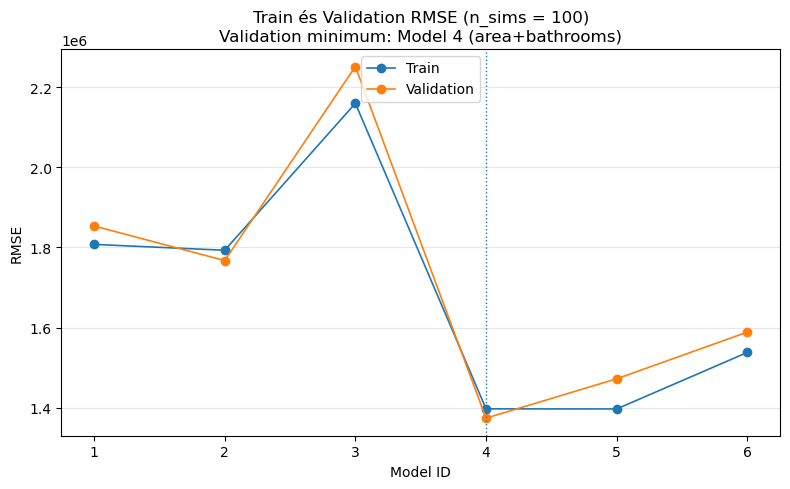

In [79]:
# ---- ÁBRA: CSAK átlag RMSE ----
fig, ax = plt.subplots(figsize=(8,5))
for label, dfp in avg_df.groupby("set"):
    ax.plot(dfp["model_id"], dfp["rmse"], marker="o", linewidth=1.2, label=label)

ax.axvline(best_id_avg, linestyle=":", linewidth=1.0)
ax.set_xticks(model_lookup["model_id"].values)
ax.set_xlabel("Model ID"); ax.set_ylabel("RMSE")
ax.set_title("Train és Validation RMSE (n_sims = 100)\nValidation minimum: Model %d (%s)" % (best_id_avg, best_label))
ax.legend(loc="upper center")
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [100]:
avg_df = pd.concat([
    pd.DataFrame({"model_id": model_lookup["model_id"].values, "crit": "AIC", "ic": AIC_mat}),
    pd.DataFrame({"model_id": model_lookup["model_id"].values, "crit": "BIC", "ic": BIC_mat})
], ignore_index=True).merge(model_lookup, on="model_id", how="left")

best_aic = int(avg_df[avg_df["crit"]=="AIC"].sort_values("ic").iloc[0]["model_id"])
best_bic = int(avg_df[avg_df["crit"]=="BIC"].sort_values("ic").iloc[0]["model_id"])

avg_df.head()

,model_id,crit,ic,size,label
0,1,AIC,13668.280052,1,area
1,2,AIC,13757.842085,1,bedrooms
2,3,AIC,13745.847004,1,stories
3,4,AIC,13556.566575,2,area+bathrooms
4,5,AIC,13573.987334,4,area+bedrooms+mainroad+guestroom


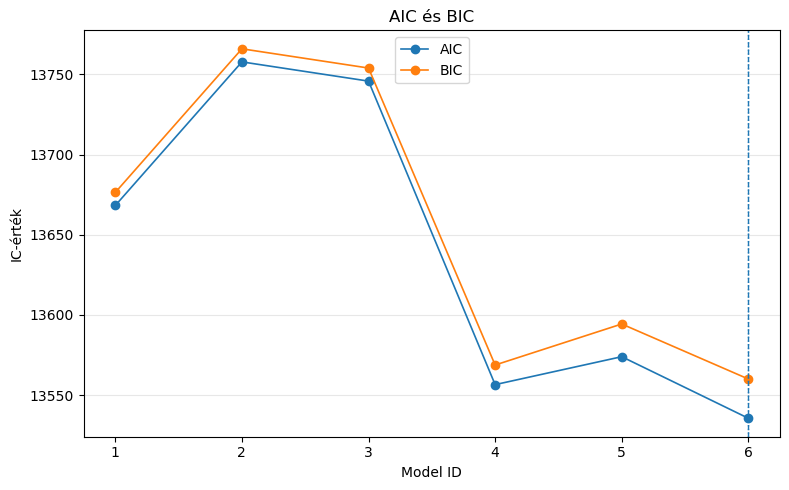

In [81]:
# ---- ÁBRA: csak átlag IC-k ----
fig, ax = plt.subplots(figsize=(8,5))
for label, dfp in avg_df.groupby("crit"):
    ax.plot(dfp["model_id"], dfp["ic"], marker="o", linewidth=1.2, label=label)

ax.axvline(best_aic, linestyle=":", linewidth=1.0)
ax.axvline(best_bic, linestyle="--", linewidth=1.0)
ax.set_xticks(model_lookup["model_id"].values)
ax.set_title("AIC és BIC")
ax.set_xlabel("Model ID"); ax.set_ylabel("IC-érték")
ax.legend(loc="upper center")
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [106]:
# ---- CROSS VALIDATION ----

# ---- DIRECT METHOD ----



# ---- LASSO 5 FOLD CV ----

lasso_df = np.empty(len(model_specs))

rmse_lasso = []

for j, ix in enumerate(model_specs):
    X_tv = trnval[[f"{k}" for k in ix]].values
    y_tv = trnval["price"].values
    X_te = test[[f"{k}" for k in ix]].values
    Y_te = test[["price"]].values
    lcv = make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        LassoCV(cv=5, random_state=int(rng_master.integers(0,1_000_000)), n_alphas=100)  # fixed
    )
    lcv.fit(X_tv, y_tv)
    yhat_lasso = lcv.predict(X_te)
    coef = lcv.named_steps["lassocv"].coef_
    lasso_df[j] = int((np.abs(coef)>1e-12).sum())
    
    rmse_lasso.append(rmse(Y_te, yhat_lasso)) 
    

lasso_rmse_pick = int(np.argmin(rmse_lasso))+1
print(rmse_lasso)
print(lasso_rmse_pick)

[2172149.0319930227, 2129007.537865731, 2091192.6796753618, 2370118.7734652823, 2342104.2049851744, 2294442.270726978]
3
